# Set-up

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import seqdata as sd
from eugene import models
from eugene.models import zoo
from eugene import plot as pl
import matplotlib.pyplot as plt

sys.path.append("/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/bin")
from plot import training_summary, scatter

In [51]:
# Model log directory
date = "2024_01_02"
rbp = "RNCMPT00103"
normalization = "log_norm"
log_dir = f"/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/models/{date}/ResidualBind/{normalization}/{rbp}"

# Check if log directory exists
if not os.path.isdir(log_dir):
    print(f"Log directory {log_dir} does not exist")

# Check if model exists
best_path = os.path.join(log_dir, "best_model.ckpt")
if not os.path.isfile(best_path):
    print(f"Model {best_path} does not exist")

In [52]:
# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Plot training summary

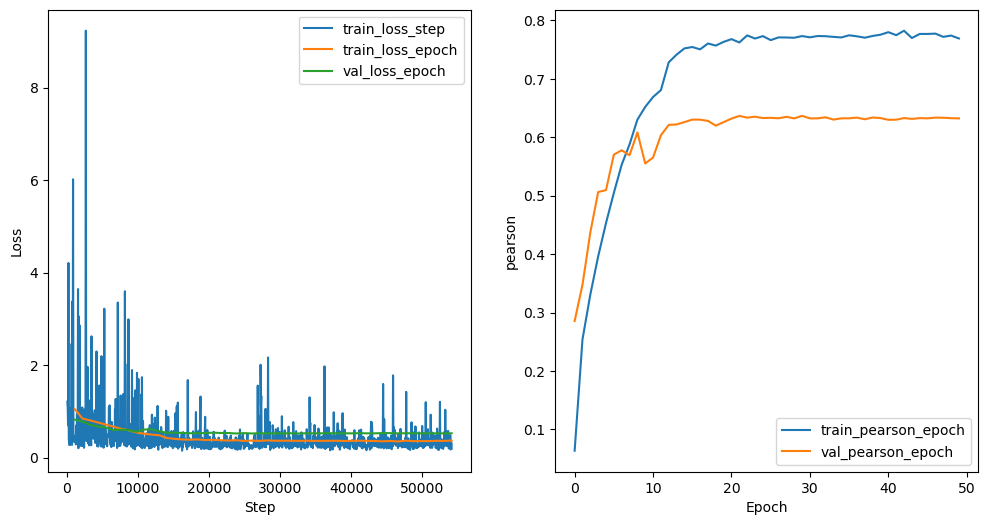

In [53]:
training_summary(log_dir, metrics=["pearson"], logger="csv", save=os.path.join(log_dir, "training_summary.png"))

# Load test dataset

In [54]:
# Load the dataset
sdata = sd.open_zarr("/cellar/users/aklie/data/ml4gland/pubs/koo21_gia/log_norm/rnacompete2013_test.zarr")
sdata.load()

<xarray.Dataset>
Dimensions:    (_sequence: 121031, _length: 41, _ohe: 4, _target: 244)
Dimensions without coordinates: _sequence, _length, _ohe, _target
Data variables:
    inputs     (_sequence, _length, _ohe) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rbp_id     (_target) <U11 'RNCMPT00100' 'RNCMPT00101' ... 'RNCMPT00009'
    rbp_index  (_target) int64 0 1 2 3 4 5 6 7 ... 237 238 239 240 241 242 243
    targets    (_sequence, _target) float32 0.795 -0.2654 -0.2193 ... 0.6552 nan

In [56]:
# Get seqs to predict on
X_test_np = sdata["inputs"].values.transpose(0, 2, 1)

# Get target vector
target_ind = np.where(sdata["rbp_id"].values == rbp)[0]
targets = sdata["targets"][:, target_ind].values.squeeze()

# Load best model

In [57]:
# Instantiate an architecture
arch = zoo.ResidualBind(
    input_len=41,
    output_dim=1
)

In [58]:
module = models.SequenceModule.load_from_checkpoint(
    os.path.join(log_dir, "best_model.ckpt"),
    arch=arch,
)

[rank: 0] Global seed set to 1234


# Get predictions

In [59]:
module.to(device).eval();

In [60]:
preds = module.predict(
    X_test_np,
    batch_size=128
).cpu().numpy().squeeze()

Predicting on batches:   0%|          | 0/945 [00:00<?, ?it/s]

# Plot performance

In [61]:
# Make output directory if it doesn't exist
outdir = os.path.join(log_dir, "performance")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [62]:
df = pd.DataFrame({
    "target": targets,
    "pred": preds
})
df.to_csv(os.path.join(outdir, "test_predictions.csv"), index=False)

In [63]:
# Plot a nice blue color
scatter(
    x=targets,
    y=preds,
    c="#4682B4",
    alpha=0.8,
    xlabel="Experimental binding scores",
    ylabel="Predicted binding scores",
    density=False,
    rasterized=True,
    s=5,
    save=os.path.join(outdir, "test_scatter.png"),
)

# DONE!

---